# Comparing FIRST and MIST
## Subcortical segmentations: volume CoV within/between scanners

In [1]:
import numpy as np
import pandas as pd
import scipy as sc

import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt

import glob
import re
import os

sns.set_theme()
sns.set_context("talk")

In [2]:
# some useful dictonaries and lists
vendor_dict = {"TRI": "Siemens", "PRI": "Siemens", "ING": "Philips", "ACH": "Philips", "GEM": "GE"}

scanner_dict = {"NOT1ACH": "Philips Achieva",
                "NOT2ING": "Philips Ingenia", 
                "NOT3GEM": "GE MR750", 
                "OXF1PRI": "Siemens Prisma 32",
                "OXF2PRI": "Siemens Prisma 64",
                "OXF3TRI": "Siemens Trio"}

scanner_code_dict = {"NOT1ACH": "Ach",
                        "NOT2ING": "Ing", 
                        "NOT3GEM": "750", 
                        "OXF1PRI": "Pri32",
                        "OXF2PRI": "Pri64",
                        "OXF3TRI": "Trio"}

basic_info_hdrs = ['session', 'scanner_name', 'vendor', 'scanner_code', 
             'scanner_type', 'scanner_typeloc', 'scan_session_num', 'scan_session', 'subject']

info_hdrs = basic_info_hdrs


In [3]:
def get_measure_type(measure_names, IDP=True):
    measure_type = []
    if IDP == True:
        for l in measure_names:
            if 'dMRI_TBSS' in l:
                measure_type = measure_type + [re.search('dMRI_(.*)_[0-9]+', l).group(1).replace('TBSS', 'dMRI ROI')]
            elif 'dMRI_xtract' in l:
                measure_type = measure_type + [re.search('dMRI_(.*)_[0-9]+', l).group(1).replace('xtract', 'dMRI tract')]
            elif 'T1_SIENAX' in l:
                measure_type = measure_type + ['FSL Tissue volumes']
            elif 'T1_GM_parcellation' in l:
                measure_type = measure_type + ['FSL GM volumes']
            elif 'T1_FIRST' in l:
                measure_type = measure_type + ['FSL Subcortical volumes']
            elif 'freesurfer' in l:
                if 'aseg' in l:
                    measure_type = measure_type + ['FreeSurfer Subcortical volumes']
                elif 'DK' in l:
                    if 'SurfArea' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical surface area (DK)']
                    elif 'GrayVol' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical volume (DK)'] 
                    elif 'ThickAvg' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical thickness (DK)']
                    elif 'MeanCurv' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical curvature (DK)']
                elif 'a2009s' in l:
                    if 'SurfArea' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical surface area (Destrieux)']
                    elif 'GrayVol' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical volume (Destrieux)'] 
                    elif 'ThickAvg' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical thickness (Destrieux)']
                    elif 'MeanCurv' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical curvature (Destrieux)']                    
            elif 'T2_FLAIR' in l:
                measure_type = measure_type + ['WM hyperintensities']
            elif 'SWI_T2star' in l:
                measure_type = measure_type + ['SWI T2* subcortex']    
            elif 'rfMRI_d25' in l:
                if 'NodeAmplitude' in l:
                    measure_type = measure_type + ['rfMRI d=25 node amplitudes']
                elif 'corr' in l:
                    measure_type = measure_type + ['rfMRI d=25 connectivities']
            elif 'rfMRI_d100' in l:
                if 'NodeAmplitude' in l:
                    measure_type = measure_type + ['rfMRI d=100 node amplitudes']
                elif 'corr' in l:
                    measure_type = measure_type + ['rfMRI d=100 connectivities']   
            else:
                measure_type = measure_type + ["other"]
    elif IDP == False:
        for l in measure_names:
            if 'dMRI' in l:        
                measure_type = measure_type + ['dMRI']
            elif 'T1w' in l:
                measure_type = measure_type + ['T1'] 
            elif 'T2' in l:
                measure_type = measure_type + ['T2']
            elif 'SWI' in l:
                measure_type = measure_type + ['SWI'] 
            elif 'fmri' in l:
                measure_type = measure_type + ['fMRI']
            elif 'rfMRI' in l:
                measure_type = measure_type + ['fMRI']
                
    measure_type = [l.replace('_', ' ') for l in measure_type]
    measure_type = [l.replace('v1', ' ') for l in measure_type]
    return measure_type

## Build main dataframe

In [4]:
studydir='/Users/shaunwarrington/OneDrive - The University of Nottingham (1)/Deliverables/Papers/NHarmony'
fig_out = f'{studydir}/pyfigs'

# Load IDP headers
hdrs = np.loadtxt(f'{studydir}/data/headers.txt', 'str')
hdrs = np.concatenate([['session'], hdrs])
hdrs = [x for x in hdrs if 'mist' not in x] # not using MIST

# Load subject-wise IDPs
idp_files = glob.glob(f'{studydir}/data/IDPs/*[!denoise].txt')
df = [pd.read_csv(f, sep=" ", index_col=None, header=None) for f in idp_files]
df = pd.concat(df, ignore_index=True)

df.columns = hdrs
df = df[df.columns.drop(list(df.filter(regex='tfMRI')))] # drop task-fMRI IDPs

print(f'{df.shape[0]} sessions')
print('The raw measures:')
df.head(5)

99 sessions
The raw measures:


,session,1_l_align_to_std_diff,1_nl_align_to_std_diff,1_nl_align_to_std_warp,1_inverse_SNR,1_inverse_CNR,2_FLAIR_align_to_T1,MRI_align_to_T1,WI_align_to_T1,fMRI_align_to_T1,...,T1_GM_parcellation_L_VIIIb_Cerebellum_vol,T1_GM_parcellation_Vermis_VIIIb_Cerebellum_vol,T1_GM_parcellation_R_VIIIb_Cerebellum_vol,T1_GM_parcellation_L_IX_Cerebellum_vol,T1_GM_parcellation_Vermis_IX_Cerebellum_vol,T1_GM_parcellation_R_IX_Cerebellum_vol,T1_GM_parcellation_L_X_Cerebellum_vol,T1_GM_parcellation_Vermis_X_Cerebellum_vol,T1_GM_parcellation_R_X_Cerebellum_vol,T2_FLAIR_WMH_volume
0,03997_NOT2ING001,0.709639,0.565298,0.068010,0.023000,0.048365,0.417115,0.817849,0.398544,0.896350,...,2109.992313,329.589582,2049.580686,1162.600140,208.419435,1462.600181,578.780475,222.489944,442.430170,1293
1,14229_NOT2ING001,0.709498,0.558609,0.074845,0.023515,0.050278,0.332084,0.655481,0.396900,0.954145,...,2143.709358,353.850084,2574.299187,1158.141840,299.850408,1511.128623,575.468728,228.350319,631.039500,2118
2,10975_OXF1PRI001,0.671640,0.532363,0.060674,0.014329,0.029774,0.506442,0.606848,0.408396,0.862284,...,2109.548870,282.620293,2201.957280,1493.439980,277.000116,1541.828000,463.729077,230.000078,399.809908,89
3,13192_OXF2PRI001,0.751898,0.578664,0.066386,0.014678,0.031013,0.467204,0.739697,0.509247,0.966793,...,2340.322330,324.540300,1955.638035,1420.989965,309.450327,1752.868617,464.880968,175.439902,432.559840,594
4,03286_OXF2PRI001,0.779914,0.612624,0.075811,0.015209,0.034127,0.489486,0.624702,0.491941,0.867948,...,2426.239281,318.269952,2279.822940,1753.326639,419.030611,1997.429920,563.281340,239.979695,533.270100,4638


#### Get the header descriptions

In [5]:
hdr_descriptions = pd.read_csv(f'{studydir}/data/hdr_descriptions.txt', sep="\r\t", names=['desc'])
hdr_descriptions["hdr"] = np.loadtxt(f'{studydir}/data/headers.txt', 'str')
                                     
hdr_descriptions = hdr_descriptions[hdr_descriptions["hdr"].str.contains("tfMRI")==False]
hdr_descriptions = hdr_descriptions[hdr_descriptions["hdr"].str.contains("mist")==False]

def hdr_desc(hdr):
    try:
        desc = hdr_descriptions.loc[hdr_descriptions.hdr == hdr, 'desc'].values[0]
    except:
        desc = hdr
    return desc


/var/folders/zl/1dgn0f017lj2m5zffnwkcyr80000gq/T/ipykernel_81641/1054213702.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  hdr_descriptions = pd.read_csv(f'{studydir}/data/hdr_descriptions.txt', sep="\r\t", names=['desc'])


#### Add session info columns

In [6]:
sublist = [t.split('_')[0] for t in df.session.values]
scan_session = [t.split('_')[1] for t in df.session.values]
scan_session_num = [t[-3:] for t in scan_session]
scanner_typeloc = [t.split('00')[0] for t in scan_session]
scanner_type = [t[-3:] for t in scanner_typeloc]

df.insert(1, 'subject', sublist)
df.insert(1, 'scan_session', scan_session)
df.insert(1, 'scan_session_num', scan_session_num)
df.insert(1, 'scanner_typeloc', scanner_typeloc)
df.insert(1, 'scanner_type', scanner_type)
df.insert(1, 'vendor', df['scanner_type'].map(vendor_dict))
df.insert(1, 'scanner_name', df['scanner_typeloc'].map(scanner_dict))
df.insert(1, 'scanner_code', df['scanner_typeloc'].map(scanner_code_dict))

df.sort_values('session', inplace=True, ignore_index=True)
df.columns = df.columns.str.strip()

# remove fMRI opts sessions
df_fmriopts = df.loc[(df['scan_session_num'] == '002') & 
                     (df['scanner_type'].isin(['GEM', 'ING']))]
df_fmriopts_idx = df_fmriopts.index.values # indices to remove from main df
df.drop(index=(df_fmriopts_idx), inplace=True) # remove from main df


### Load in MIST values

In [7]:
# T1
mistdf = pd.read_csv(f"{studydir}/data/mist_T1_vols", sep=" ", index_col=None)
mistdf.rename(columns=lambda s: s.replace("mist", "mist1"), inplace=True)
mistdf = mistdf.rename(columns={'index': 'session'})

# T1+T2
temp = pd.read_csv(f"{studydir}/data/mist_vols", sep=" ", index_col=None)
temp.rename(columns=lambda s: s.replace("mist", "mist2"), inplace=True)
temp = temp.rename(columns={'index': 'session'})

mistdf = pd.merge(mistdf, temp, on="session", how="left")

# T1+T2+FA
temp = pd.read_csv(f"{studydir}/data/mist_FA_vols", sep=" ", index_col=None)
temp.rename(columns=lambda s: s.replace("mist", "mist3"), inplace=True)
temp = temp.rename(columns={'index': 'session'})

mistdf = pd.merge(mistdf, temp, on="session", how="left")


#### Load FreeSurfer IDPs - aseg lh.aparc.DKTatlas rh.aparc.DKTatlas lh.aparc.a2009s rh.aparc.a2009s
##### only using aseg here but loading all for ease...

In [9]:
###### aseg
measure_name = 'aseg'
idp_files = glob.glob(f'{studydir}/data/freesurfer_stats/{measure_name}/*')
tempdf = pd.DataFrame()
for f in idp_files:
    d = pd.read_csv(f, sep="\s+", index_col=None)
    d['session'] = os.path.basename(f)
    tempdf = pd.concat((tempdf, d), ignore_index=True)
    
# get volumes
val_cols = ['Volume_mm3']
tempdf = tempdf[['StructName', 'session'] + val_cols]
tempdf = tempdf.pivot(index='session', columns='StructName', values=val_cols)
tempdf.columns = ['_'.join(col).strip() for col in tempdf.columns.values]
tempdf.reset_index(inplace=True, drop=False)

# drop WM measures
tempdf = tempdf[tempdf.columns.drop(list(tempdf.filter(regex='WM-')))]

# add prefix
tempdf = tempdf.add_prefix(f'freesurfer_{measure_name}_')
tempdf.rename(columns={f'freesurfer_{measure_name}_session': 'session'}, inplace=True)

# build FreeSurfer dataframe
df_fs = tempdf.copy()

###### aparc cortical atlases
for measure_name in ['lh.aparc.DKTatlas', 'rh.aparc.DKTatlas', 'lh.aparc.a2009s', 'rh.aparc.a2009s']:
    idp_files = glob.glob(f'{studydir}/data/freesurfer_stats/{measure_name}/*')
    tempdf = pd.DataFrame()
    for f in idp_files:
        d = pd.read_csv(f, sep="\s+", index_col=None)
        d['session'] = os.path.basename(f)
        tempdf = pd.concat((tempdf, d), ignore_index=True)

    # get StructName, SurfArea, GrayVol, ThickAvg, MeanCurv
    val_cols = ['SurfArea', 'GrayVol', 'ThickAvg', 'MeanCurv']
    tempdf = tempdf[['StructName', 'session'] + val_cols]
    tempdf = tempdf.pivot(index='session', columns='StructName', values=val_cols)
    tempdf.columns = ['_'.join(col).strip() for col in tempdf.columns.values]
    tempdf.reset_index(inplace=True, drop=False)

    # add prefix
    tempdf = tempdf.add_prefix(f'freesurfer_{measure_name}_')
    tempdf.rename(columns={f'freesurfer_{measure_name}_session': 'session'}, inplace=True)

    df_fs = pd.merge(df_fs, tempdf, on="session")

# for aseg, only keep subcortical
for h in ['Vent', 'CSF', 'CC', 'choroid-plexus', 'vessel', 'Optic-Chiasm', 'Cerebellum']:
    df_fs = df_fs[df_fs.columns.drop(list(df_fs.filter(regex=h)))]


#### Useful main data (df) lists

In [11]:
df.sort_values('session', inplace=True, ignore_index=True)

# subject, vendor and scanner lists
sub_list = df.subject.unique()
ven_list = df.vendor.unique()
scanner_typeloc_list = df.scanner_typeloc.unique()
scanner_type_list = df.scanner_type.unique()

reptlist = [["13192", "OXF1PRI"],
            ["14229", "OXF2PRI"],
            ["14230", "OXF3TRI"],
            ["14482", "NOT1ACH"]]

## IDP-wise CoV in FIRST and MIST

In [12]:
def get_stats(df):
    mn = df.mean(axis=0).abs()
    std = df.std(axis=0).abs()
    med = df.median(axis=0).abs()
    mad = df.mad(axis=0)
    mad_med = mad/med
    cv = std/mn
    return mn, med, mad, cv, mad_med

def get_null_corr(figobj, nsamp1=10, nsamp2=6, niter=1000):
    nullcorr = np.zeros((niter,))
    for i in range(0, niter):
        nullcorr[i] = sc.stats.spearmanr(np.random.choice(range(nsamp1), nsamp1, replace=False), 
                           np.random.choice(range(nsamp1), nsamp1, replace=False), axis=1)[0]
        
    null_iqr = np.percentile(nullcorr, [25, 75])
    
    if hasattr(figobj, 'get_xlim'):
        xlims = figobj.get_xlim()[0], figobj.get_xlim()[1]
        ylims = figobj.get_ylim()[0], figobj.get_ylim()[1]
        figobj.fill_between([xlims[0]-1, xlims[1]+1], null_iqr[0], null_iqr[1], color='red', alpha=0.2)
        figobj.set_xlim(xlims[0], xlims[1])
        figobj.set_ylim(0, ylims[1])
    else:
        ylims = figobj.axes[0][0].get_ylim()[0], figobj.axes[0][0].get_ylim()[1]
        
        for ax in figobj.axes[0]:
            xlims = ax.get_xlim()[0], ax.get_xlim()[1]
            ax.fill_between([xlims[0]-1, xlims[1]+1], null_iqr[0], null_iqr[1], color='red', alpha=0.2)
            ax.set_xlim(xlims[0], xlims[1])
            
        g.set(ylim=(ylims[0], ylims[1]))


In [13]:
# combine freesurfer data and prepare for CoV calculations
fs_hdrs = list(df_fs.filter(regex='aseg').columns.values)
fs_hdrs.remove('freesurfer_aseg_Volume_mm3_Brain-Stem')

df_fs = df_fs[['session'] + fs_hdrs]

# sum Accumbens-area and Caudate
df_fs['freesurfer_aseg_Volume_mm3_Left-Caudate+Accumbens'] = df_fs['freesurfer_aseg_Volume_mm3_Left-Caudate'] + df_fs['freesurfer_aseg_Volume_mm3_Left-Accumbens-area']
df_fs['freesurfer_aseg_Volume_mm3_Right-Caudate+Accumbens'] = df_fs['freesurfer_aseg_Volume_mm3_Right-Caudate'] + df_fs['freesurfer_aseg_Volume_mm3_Right-Accumbens-area']

fs_hdrs.append('freesurfer_aseg_Volume_mm3_Left-Caudate+Accumbens')
fs_hdrs.append('freesurfer_aseg_Volume_mm3_Right-Caudate+Accumbens')

for l in ['freesurfer_aseg_Volume_mm3_Left-Caudate', 'freesurfer_aseg_Volume_mm3_Right-Caudate', 
          'freesurfer_aseg_Volume_mm3_Left-Accumbens-area', 'freesurfer_aseg_Volume_mm3_Right-Accumbens-area',
         ]:
    df_fs.drop(l, axis=1, inplace=True)
    fs_hdrs.remove(l)


In [14]:
# mist includes:

# get IDPs
first_hdrs = ['T1_FIRST_left_thalamus', 'T1_FIRST_right_thalamus',
              'T1_FIRST_left_pallidum', 'T1_FIRST_right_pallidum',
              'T1_FIRST_left_putamen', 'T1_FIRST_right_putamen',
              'T1_FIRST_left_hippocampus', 'T1_FIRST_right_hippocampus',
              'T1_FIRST_left_amygdala', 'T1_FIRST_right_amygdala',
              'T1_FIRST_left_caudate', 'T1_FIRST_right_caudate',
              'T1_FIRST_left_accumbens', 'T1_FIRST_right_accumbens'
             ]

mist_hdrs = ['mist_left_thalamus', 'mist_right_thalamus',
             'mist_left_pallidum', 'mist_right_pallidum',
             'mist_left_putamen','mist_right_putamen',
             'mist_left_hippocampus', 'mist_right_hippocampus',
             'mist_left_amygdala', 'mist_right_amygdala',
             'mist_left_caudate_accumbens', 'mist_right_caudate_accumbens'
             ]

mist1_hdrs = [h.replace('mist', 'mist1') for h in mist_hdrs]
mist2_hdrs = [h.replace('mist', 'mist2') for h in mist_hdrs]
mist3_hdrs = [h.replace('mist', 'mist3') for h in mist_hdrs]

# sum FIRST caudate and accumbens to match MIST
seg_df = df[basic_info_hdrs + first_hdrs].copy()
seg_df['T1_FIRST_left_caudate+accum'] = seg_df['T1_FIRST_left_caudate'] + seg_df['T1_FIRST_left_accumbens']
seg_df['T1_FIRST_right_caudate+accum'] = seg_df['T1_FIRST_right_caudate'] + seg_df['T1_FIRST_right_accumbens']

first_hdrs.append('T1_FIRST_left_caudate+accum')
first_hdrs.append('T1_FIRST_right_caudate+accum')
for l in ['T1_FIRST_left_caudate', 'T1_FIRST_right_caudate', 'T1_FIRST_left_accumbens', 'T1_FIRST_right_accumbens']:
    seg_df.drop(l, axis=1, inplace=True)
    first_hdrs.remove(l)
    
idp_hdrs = first_hdrs + mist1_hdrs + mist2_hdrs + mist3_hdrs + fs_hdrs
seg_df = pd.merge(seg_df, mistdf, on="session", how="left")
seg_df = pd.merge(seg_df, df_fs, on="session", how="left")


In [15]:
seg_df

,session,scanner_name,vendor,scanner_code,scanner_type,scanner_typeloc,scan_session_num,scan_session,subject,T1_FIRST_left_thalamus,...,freesurfer_aseg_Volume_mm3_Left-Pallidum,freesurfer_aseg_Volume_mm3_Left-Putamen,freesurfer_aseg_Volume_mm3_Left-Thalamus,freesurfer_aseg_Volume_mm3_Right-Amygdala,freesurfer_aseg_Volume_mm3_Right-Hippocampus,freesurfer_aseg_Volume_mm3_Right-Pallidum,freesurfer_aseg_Volume_mm3_Right-Putamen,freesurfer_aseg_Volume_mm3_Right-Thalamus,freesurfer_aseg_Volume_mm3_Left-Caudate+Accumbens,freesurfer_aseg_Volume_mm3_Right-Caudate+Accumbens
0,03286_NOT1ACH001,Philips Achieva,Philips,Ach,ACH,NOT1ACH,001,NOT1ACH001,03286,8727,...,2036.3,4835.1,9143.1,1831.2,4569.6,2316.0,5119.7,7621.8,4026.2,4316.7
1,03286_NOT2ING001,Philips Ingenia,Philips,Ing,ING,NOT2ING,001,NOT2ING001,03286,8805,...,2056.9,4645.0,8496.3,2011.9,4495.6,2047.1,4902.3,7547.0,3678.2,4187.3
2,03286_NOT3GEM001,GE MR750,GE,750,GEM,NOT3GEM,001,NOT3GEM001,03286,8992,...,2015.1,5007.8,8761.6,1654.6,4284.6,2174.8,5006.6,7969.5,4198.4,4398.5
3,03286_OXF1PRI001,Siemens Prisma 32,Siemens,Pri32,PRI,OXF1PRI,001,OXF1PRI001,03286,9001,...,1988.0,4863.1,9312.7,1671.4,4568.0,2127.3,5001.5,8152.7,3924.1,4191.8
4,03286_OXF2PRI001,Siemens Prisma 64,Siemens,Pri64,PRI,OXF2PRI,001,OXF2PRI001,03286,8883,...,2009.4,4997.5,8802.2,1812.7,4578.4,2067.6,5075.8,7937.1,4064.2,4291.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,14482_NOT2ING001,Philips Ingenia,Philips,Ing,ING,NOT2ING,001,NOT2ING001,14482,8621,...,1968.4,4599.0,8198.3,1858.1,4389.2,1974.4,4795.8,7329.3,3303.3,3481.7
76,14482_NOT3GEM001,GE MR750,GE,750,GEM,NOT3GEM,001,NOT3GEM001,14482,8820,...,1825.2,4973.6,7632.8,1681.9,4244.1,1854.9,5053.4,7269.9,3662.1,3865.3
77,14482_OXF1PRI001,Siemens Prisma 32,Siemens,Pri32,PRI,OXF1PRI,001,OXF1PRI001,14482,8754,...,1943.4,4709.5,7709.4,1666.7,4426.5,1936.3,5007.0,7370.9,3371.2,3518.3
78,14482_OXF2PRI001,Siemens Prisma 64,Siemens,Pri64,PRI,OXF2PRI,001,OXF2PRI001,14482,8773,...,1887.9,4867.4,8323.3,1726.4,4595.8,1912.6,5012.4,7805.2,3356.5,3661.3


In [16]:
# get CoV for FIRST IDPs within and between scanners
seg_cov = pd.DataFrame()

# within-scanner CoV
for sub, sca in zip(["13192", "14229", "14230", "14482"], ["OXF1PRI", "OXF2PRI", "OXF3TRI", "NOT1ACH"]):
    mn, med, mad, cv, mad_med = get_stats(seg_df[(seg_df.subject == sub) & 
                                                   (seg_df.scanner_typeloc == sca)][idp_hdrs])
    measure_type = get_measure_type(cv.index)
    tempdf = pd.DataFrame({"IDP": cv.index, "value": cv, 'subject': sub, 'scanners': 'within\nscanner'})
    seg_cov = pd.concat((seg_cov, tempdf))
    
# between-scanner CoV
for sub in ["13192", "14229", "14230", "14482"]:
    mn, med, mad, cv, mad_med = get_stats(seg_df[(seg_df.subject == sub) & 
                                                   (seg_df.scan_session_num == '001')][idp_hdrs])
    measure_type = get_measure_type(cv.index)
    tempdf = pd.DataFrame({"IDP": cv.index, "value": cv, 'subject': sub, 'scanners': 'between\nscanner'})
    seg_cov = pd.concat((seg_cov, tempdf))
    
# combine left and right - just remove _left and _right from IDP names
seg_cov['IDP'] = seg_cov['IDP'].str.replace('T1_', '')
seg_cov['IDP'] = seg_cov['IDP'].str.replace('left_', '')
seg_cov['IDP'] = seg_cov['IDP'].str.replace('right_', '')
seg_cov['IDP'] = seg_cov['IDP'].str.replace('Left-', '')
seg_cov['IDP'] = seg_cov['IDP'].str.replace('Right-', '')
seg_cov['IDP'] = seg_cov['IDP'].str.replace('_aseg_Volume_mm3_', ' ')
seg_cov['IDP'] = seg_cov['IDP'].str.replace('_', ' ')
seg_cov['IDP'] = seg_cov['IDP'].str.title()
seg_cov['IDP'] = seg_cov['IDP'].str.replace('First', 'FIRST')
seg_cov['IDP'] = seg_cov['IDP'].str.replace('Mist', 'MIST')


# add a method column denoting whether FIRST or MIST
seg_cov['Method'] = seg_cov['IDP']
seg_cov.loc[seg_cov['Method'].str.contains('FIRST'), 'Method'] = 'Unimodal (FIRST: T1)'
seg_cov.loc[seg_cov['Method'].str.contains('MIST1'), 'Method'] = 'Unimodal (MIST: T1)'
seg_cov.loc[seg_cov['Method'].str.contains('MIST2'), 'Method'] = 'Multimodal (MIST: T1, T2)'
seg_cov.loc[seg_cov['Method'].str.contains('MIST3'), 'Method'] = 'Multimodal (MIST: T1, T2, FA)'
seg_cov.loc[seg_cov['Method'].str.contains('Freesurfer'), 'Method'] = 'Unimodal (FreeSurfer: T1)'


/var/folders/zl/1dgn0f017lj2m5zffnwkcyr80000gq/T/ipykernel_81641/478565759.py:5: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  mad = df.mad(axis=0)
/var/folders/zl/1dgn0f017lj2m5zffnwkcyr80000gq/T/ipykernel_81641/478565759.py:5: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  mad = df.mad(axis=0)
/var/folders/zl/1dgn0f017lj2m5zffnwkcyr80000gq/T/ipykernel_81641/478565759.py:5: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  mad = df.mad(axis=0)
/var/folders/zl/1dgn0f017lj2m5zffnwkcyr80000gq/T/ipykernel_81641/478565759.py:5: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df

## IDP-wise subject ranking

In [17]:
corrdf = []
for j, h in enumerate(idp_hdrs):
    arr = np.zeros((len(sub_list), len(scanner_typeloc_list)))
    for i, sca in enumerate(scanner_typeloc_list):
        arr[:, i] = seg_df[(seg_df.scan_session_num == '001') & (seg_df.scanner_typeloc == sca)][h]

    corr = sc.stats.spearmanr(arr, axis=0, nan_policy='omit')[0]
    corr = corr[np.triu_indices_from(corr, k=1)]
    
    corrdf.append(np.mean(corr))
    
corrdf = pd.DataFrame({'IDP':idp_hdrs, 'value':corrdf})
measure_type = get_measure_type(corrdf.IDP)
corrdf['IDP_type'] = measure_type
corrdf['scanners'] = 'All scanners'

# Siemens only
corrdf_sie = []
siemens_list = ['OXF1PRI', 'OXF2PRI', 'OXF3TRI']
for j, h in enumerate(idp_hdrs):
    arr = np.zeros((len(sub_list), len(siemens_list)))
    for i, sca in enumerate(siemens_list):
        arr[:, i] = seg_df[(seg_df.scan_session_num == '001') & (seg_df.vendor == 'Siemens') & (seg_df.scanner_typeloc == sca)][h]

    corr = sc.stats.spearmanr(arr, axis=0, nan_policy='omit')[0]
    corr = corr[np.triu_indices_from(corr, k=1)]
    
    corrdf_sie.append(np.mean(corr))
    
corrdf_sie = pd.DataFrame({'IDP':idp_hdrs, 'value':corrdf_sie})
measure_type = get_measure_type(corrdf_sie.IDP)
corrdf_sie['IDP_type'] = measure_type
corrdf_sie['scanners'] = 'Siemens only'

# combine dataframes
# IDP-category-wise box plots
plotdf = pd.concat((corrdf, corrdf_sie))

# combine left and right - just remove _left and _right from IDP names
plotdf['IDP'] = plotdf['IDP'].str.replace('T1_', '')
plotdf['IDP'] = plotdf['IDP'].str.replace('left_', '')
plotdf['IDP'] = plotdf['IDP'].str.replace('right_', '')
plotdf['IDP'] = plotdf['IDP'].str.replace('Left-', '')
plotdf['IDP'] = plotdf['IDP'].str.replace('Right-', '')
plotdf['IDP'] = plotdf['IDP'].str.replace('_aseg_Volume_mm3_', ' ')
plotdf['IDP'] = plotdf['IDP'].str.replace('_', ' ')
plotdf['IDP'] = plotdf['IDP'].str.title()
plotdf['IDP'] = plotdf['IDP'].str.replace('First', 'FIRST')
plotdf['IDP'] = plotdf['IDP'].str.replace('Mist', 'MIST')


# add a method column denoting whether FIRST or MIST
plotdf['Method'] = plotdf['IDP']
plotdf.loc[plotdf['Method'].str.contains('FIRST'), 'Method'] = 'Unimodal (FIRST: T1)'
plotdf.loc[plotdf['Method'].str.contains('MIST1'), 'Method'] = 'Unimodal (MIST: T1)'
plotdf.loc[plotdf['Method'].str.contains('MIST2'), 'Method'] = 'Multimodal (MIST: T1, T2)'
plotdf.loc[plotdf['Method'].str.contains('MIST3'), 'Method'] = 'Multimodal (MIST: T1, T2, FA)'
plotdf.loc[plotdf['Method'].str.contains('Freesurfer'), 'Method'] = 'Unimodal (FreeSurfer: T1)'



## plot

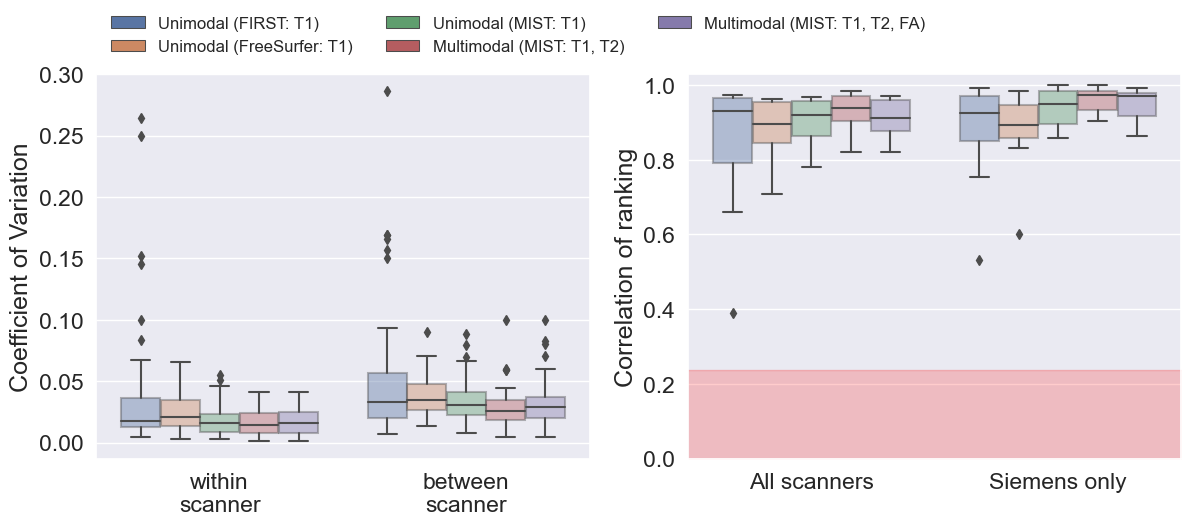

In [22]:
sns.set(font_scale = 1.5)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# CoV
g = sns.boxplot(data=seg_cov, x='scanners', y='value', hue='Method', 
                boxprops={'alpha': 0.4}, palette="deep", ax=axes[0],
               hue_order=['Unimodal (FIRST: T1)', 'Unimodal (FreeSurfer: T1)', 
                          'Unimodal (MIST: T1)', 'Multimodal (MIST: T1, T2)', 
                          'Multimodal (MIST: T1, T2, FA)'])
axes[0].set_ylabel('Coefficient of Variation');
axes[0].set_xlabel('');
axes[0].legend(loc='center left', frameon=False, fontsize=12, bbox_to_anchor=(0, 1.1), ncol=3)

# CorrRanking
g = sns.boxplot(data=plotdf, x='scanners', y='value', hue='Method', 
                boxprops={'alpha': 0.4}, ax=axes[1],
               hue_order=['Unimodal (FIRST: T1)', 'Unimodal (FreeSurfer: T1)', 
                          'Unimodal (MIST: T1)', 'Multimodal (MIST: T1, T2)', 
                          'Multimodal (MIST: T1, T2, FA)'])
axes[1].set_xlabel('');
axes[1].set_ylabel('Correlation of ranking');
axes[1].legend([], [], frameon=False);
# axes[1].legend(loc='lower right', fontsize=14, frameon=False);

get_null_corr(g)

plt.savefig(f'{fig_out}/mist_cov_corrrank.png', dpi=500, bbox_inches='tight')

In [23]:
seg_cov.groupby(['Method', 'scanners']).median()

/var/folders/zl/1dgn0f017lj2m5zffnwkcyr80000gq/T/ipykernel_81641/1788984808.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  seg_cov.groupby(['Method', 'scanners']).median()


value
Method                        scanners                  
Multimodal (MIST: T1, T2)     between\nscanner  0.025434
                              within\nscanner   0.014523
Multimodal (MIST: T1, T2, FA) between\nscanner  0.029166
                              within\nscanner   0.015951
Unimodal (FIRST: T1)          between\nscanner  0.033417
                              within\nscanner   0.017698
Unimodal (FreeSurfer: T1)     between\nscanner  0.034553
                              within\nscanner   0.020916
Unimodal (MIST: T1)           between\nscanner  0.030438
                              within\nscanner   0.016038

In [24]:
plotdf.groupby(['Method', 'scanners']).median()

/var/folders/zl/1dgn0f017lj2m5zffnwkcyr80000gq/T/ipykernel_81641/1219575744.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plotdf.groupby(['Method', 'scanners']).median()


value
Method                        scanners              
Multimodal (MIST: T1, T2)     All scanners  0.937778
                              Siemens only  0.973737
Multimodal (MIST: T1, T2, FA) All scanners  0.911111
                              Siemens only  0.969697
Unimodal (FIRST: T1)          All scanners  0.930505
                              Siemens only  0.925253
Unimodal (FreeSurfer: T1)     All scanners  0.895354
                              Siemens only  0.892929
Unimodal (MIST: T1)           All scanners  0.918788
                              Siemens only  0.949495